# CSE425: Neural Networks

## Project

In [2]:
!pip install torch torchvision datasets transformers scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
# Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from torch.utils.data import TensorDataset, DataLoader

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 0/10, Loss: 0.0074
Epoch 1/10, Loss: 0.0054
Epoch 2/10, Loss: 0.0040
Epoch 3/10, Loss: 0.0030
Epoch 4/10, Loss: 0.0024
Epoch 5/10, Loss: 0.0021
Epoch 6/10, Loss: 0.0020
Epoch 7/10, Loss: 0.0019
Epoch 8/10, Loss: 0.0018
Epoch 9/10, Loss: 0.0018

Using autoencoder,
Silhouette Score:  0.1566
Davies-Bouldin Index:  2.0936
Calinski–Harabasz Index:  35.6569
--------------------
Using S-BERT,
Silhouette Score:  0.0511
Davies-Bouldin Index:  3.2256
Calinski–Harabasz Index:  8.0196


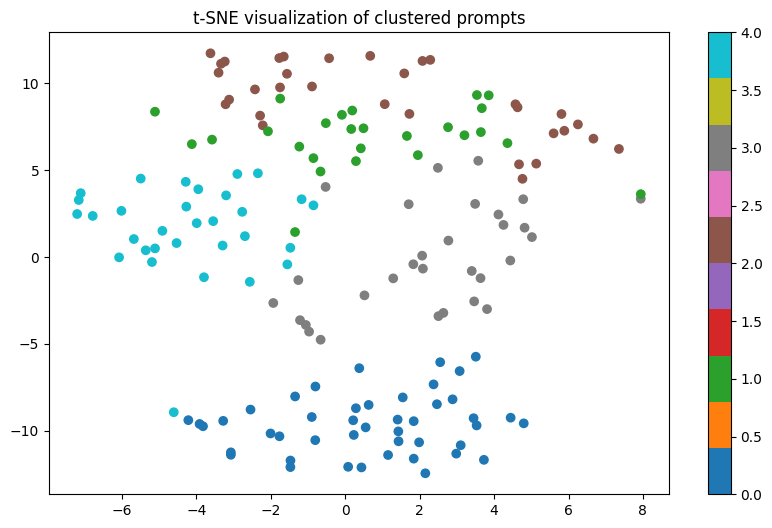

In [3]:
# Dataset Loading
dataset = load_dataset("openai/openai_humaneval")
data = dataset['test']
texts = [item['prompt'] for item in data]

# Text Embessing using S-BERT
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, show_progress_bar=True)


# Hyperparameter Tuning
input_size = embeddings.shape[1]
hidden_size = 256
latent_size = 64
# output_size = 10
learning_rate = 0.001
batch_size = 32
epochs = 10

# Autoencoder Class
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

# Dataloader
X = torch.tensor(embeddings, dtype = torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)


# Initializing Model, Loss Function, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(input_size, latent_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


# Training Loop
for epoch in range(epochs):
    total_loss = 0.0

    model.train()

    for (batch_emb,) in loader:
        batch_emb = batch_emb.to(device)
        recon, _ = model(batch_emb)
        loss = criterion(recon, batch_emb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_emb.size(0)

    avg_loss = total_loss / len(loader.dataset)

    print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")


# Model Evaluation
model.eval()

with torch.no_grad():
    _, latent_vectors = model(X.to(device))
    latent_vectors = latent_vectors.cpu().numpy()


# Clustering with K-Means
kmeans = KMeans(n_clusters = 5)
clusters = kmeans.fit_predict(latent_vectors)

kmeans_sbert = KMeans(n_clusters=5, random_state=42)
clusters_ks = kmeans_sbert.fit_predict(embeddings)

# Evaluation Metrics
sil_score = silhouette_score(latent_vectors, clusters)
db_score = davies_bouldin_score(latent_vectors, clusters)
ch_score  = calinski_harabasz_score(latent_vectors, clusters)

sil_ks = silhouette_score(embeddings, clusters_ks)
db_ks = davies_bouldin_score(embeddings, clusters_ks)
ch_ks  = calinski_harabasz_score(embeddings, clusters_ks)

print()
print("Using autoencoder,")
print(f"Silhouette Score: {sil_score : .4f}")
print(f"Davies-Bouldin Index: {db_score : .4f}")
print(f"Calinski–Harabasz Index: {ch_score : .4f}")

print("-" * 20)

print("Using S-BERT,")
print(f"Silhouette Score: {sil_ks : .4f}")
print(f"Davies-Bouldin Index: {db_ks : .4f}")
print(f"Calinski–Harabasz Index: {ch_ks : .4f}")

# Visualization with t-SNE
tsne = TSNE(n_components = 2, perplexity = 30)
reduced = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c = clusters, cmap = 'tab10')
plt.title("t-SNE visualization of clustered prompts")
plt.colorbar()
plt.show()